# Demand forecasting with the Temporal Fusion Transformer

Our example is a demand forecast from the [Stallion kaggle competition](https://www.kaggle.com/utathya/future-volume-prediction).

In [68]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
%matplotlib inline
os.chdir("E:\projects\pyTorch\stallion")

In [15]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [79]:
def generateDummyData(peopleCount,numOfPersonas,strtDate,endDate,frequency):
    date_rng = pd.date_range(start=strtDate, end=endDate, freq=frequency)
    df = pd.DataFrame(date_rng, columns=['date'])

    for userNum in range(0, peopleCount):
        df['counter'] = range(1, 1 + len(df))           # Row ID
        df['userID'] = userNum                          # UserID

        userPersona = userNum%numOfPersonas+1
        #df ['amount'] = 1+(df['counter']%(userPersona+2)==0)*1
        df ['amount'] = 1+(df['counter']%(5)==0)*1

        if userNum == 0:
            finalDf = df.copy()  # Important - this is how you copy dataframes
        else:
            finalDf = finalDf.append(df, ignore_index=True)
    return finalDf

## Generate dummy data

In [85]:
# Generate dummy data
data = generateDummyData(peopleCount=20,numOfPersonas=1,strtDate='1/1/18',endDate='31/12/21',frequency='d')

### Review dummy data

In [86]:
#data.describe
data.dtypes

date       datetime64[ns]
counter             int64
userID              int64
amount              int32
dtype: object

In [87]:
#Three lines to make our compiler able to draw:
import sys
import matplotlib
matplotlib.use('Agg')

import pandas as pd
import matplotlib.pyplot as plt

In [88]:
data[(data['date']<='28/02/2018') & (data['userID'] < 5)]

,date,counter,userID,amount
0,2018-01-01,1,0,1
1,2018-01-02,2,0,1
2,2018-01-03,3,0,1
3,2018-01-04,4,0,1
4,2018-01-05,5,0,2
...,...,...,...,...
5898,2018-02-24,55,4,2
5899,2018-02-25,56,4,1
5900,2018-02-26,57,4,1
5901,2018-02-27,58,4,1


<Figure size 432x288 with 0 Axes>

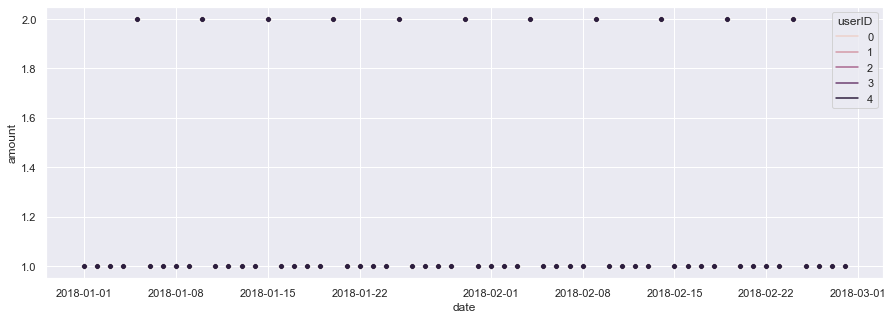

<Figure size 432x288 with 0 Axes>

In [89]:
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.figure(figsize=(15,5))  # width and height

# Plot the responses for different events and regions
df=data[(data['date']<='28/02/2018') & (data['userID'] < 5)]  # Forgetting the brackets always trips me up!
sns.lineplot(data=df,x="date", y="amount",hue='userID',linestyle='',marker='o')
plt.figure() 

<Figure size 1080x360 with 0 Axes>

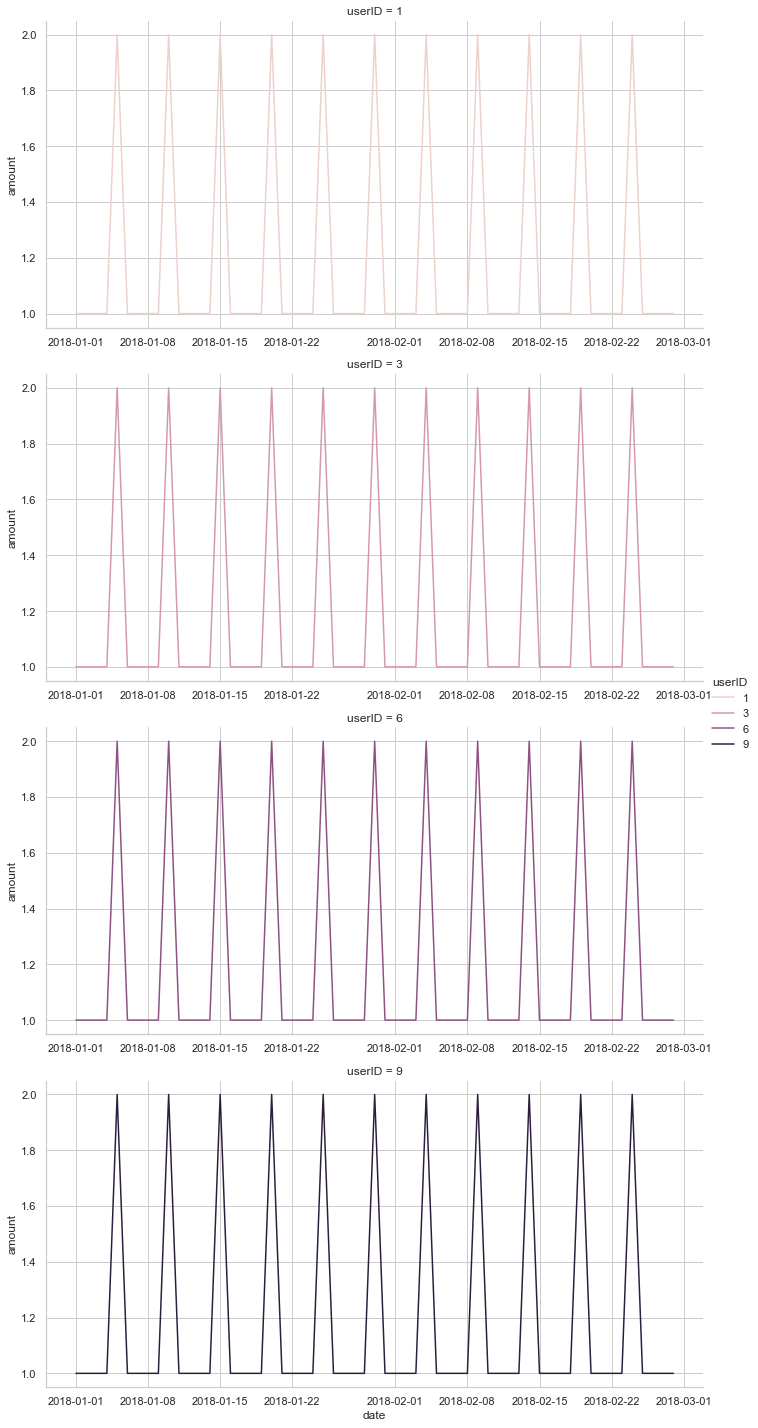

In [90]:
import seaborn as sns
plt.figure(figsize=(15,5))  # width and height
sns.set_theme(style="whitegrid")
palette = sns.color_palette("rocket_r")

# Plot the responses for different events and regions
df=data[(data['date']<='28/02/2018') & (data['userID'].isin([1, 3,6,9]))]  # Forgetting the brackets always trips me up!

g1 = sns.relplot(
    data=df,
    x="date", y="amount",
    hue="userID", col="userID",
    kind="line",
    height=5, aspect=2, facet_kws=dict(sharex=False), col_wrap=1, 
)

In [91]:
# add time index where 0 is the earliest date.
data["time_idx"] = data["date"].apply(pd.Timestamp.toordinal)
data["time_idx"] -= data["time_idx"].min()
data.head()

,date,counter,userID,amount,time_idx
0,2018-01-01,1,0,1,0
1,2018-01-02,2,0,1,1
2,2018-01-03,3,0,1,2
3,2018-01-04,4,0,1,3
4,2018-01-05,5,0,2,4


<AxesSubplot:xlabel='date'>

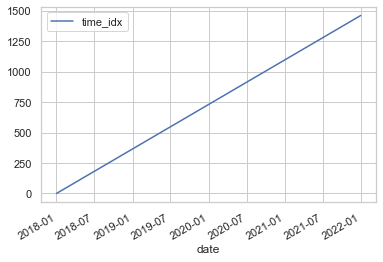

In [92]:
data.plot(x="date",y="time_idx")

In [93]:
data.sample(10, random_state=521) # Randomly sample 10 rows

,date,counter,userID,amount,time_idx
19185,2018-07-12,193,13,1,192
3272,2018-12-17,351,2,1,350
14733,2018-05-04,124,10,1,123
16719,2019-10-11,649,11,1,648
17551,2018-01-20,20,12,2,19
26480,2018-07-02,183,18,1,182
10097,2021-08-24,1332,6,1,1331
15156,2019-07-01,547,10,1,546
15112,2019-05-18,503,10,1,502
3354,2019-03-09,433,2,1,432


In [94]:
# Move column to the front - Inserted by me
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)

move_column_inplace(data,"time_idx",0)

In [95]:
data.describe()

,time_idx,counter,userID,amount
count,29220.00000,29220.00000,29220.00000,29220.000000
mean,730.00000,731.00000,9.50000,1.199863
std,421.76149,421.76149,5.76638,0.399904
min,0.00000,1.00000,0.00000,1.000000
25%,365.00000,366.00000,4.75000,1.000000
50%,730.00000,731.00000,9.50000,1.000000
75%,1095.00000,1096.00000,14.25000,1.000000
max,1460.00000,1461.00000,19.00000,2.000000


### Create dataset and dataloaders

In [96]:
max_prediction_length = 7  # Predict the next 7 days
max_encoder_length = 24    # the maximum length of the history from which a model will build features before forecasting/predicting/decoding
training_cutoff = data["time_idx"].max() - max_prediction_length  # split point for training vs test data

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],   # feed in the training data
    time_idx="time_idx",                             # point to the time index
    target="amount",                                 # the thing you are trying to forecast
    group_ids=["userID"],                            # distinct groups such as users or shops
    min_encoder_length=max_encoder_length // 2,      # keep encoder length long (as it is in the validation set) The // will  divide max_encoder_length by 2, and only keep the whole number component.
    max_encoder_length=max_encoder_length,           # the maximum history used to forecast
    min_prediction_length=1,                         # Num of periods ahead to forecast
    max_prediction_length=max_prediction_length,
    static_categoricals=[],                          # These can be strings such as product or entity ID (e.g. SKU)
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["amount"],
    target_normalizer=GroupNormalizer(
        groups=["userID"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [97]:
training

## Create baseline model

In [98]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.2857142984867096

## Train the Temporal Fusion Transformer

### Find optimal learning rate

Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).

In [99]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=6,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 4.4k


Global seed set to 42
Finding best initial lr: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


suggested learning rate: 0.46773514128719856


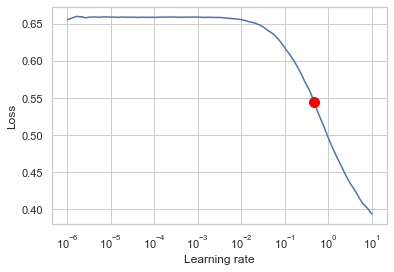

In [101]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

If you have troubles training the model and get an error ```AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'```, consider either uninstalling tensorflow or first execute

```
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
```.

In [106]:
# configure network and trainer

# The criteria on which to stop the trainign early
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min") 

lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 69.8k


Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.

In [107]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Global seed set to 42


Epoch 0:  97%|█████████▋| 30/31 [00:05<00:00,  5.12it/s, loss=0.373, v_num=13, train_loss_step=0.265]
Validating: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████▋| 30/31 [00:05<00:00,  5.18it/s, loss=0.121, v_num=13, train_loss_step=0.0731, val_loss=0.261, train_loss_epoch=0.438]
Validating: 0it [00:00, ?it/s]
Epoch 2:  65%|██████▍   | 20/31 [00:04<00:02,  4.67it/s, loss=0.0663, v_num=13, train_loss_step=0.0628, val_loss=0.079, train_loss_epoch=0.160]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Epoch 2:  97%|█████████▋| 30/31 [00:06<00:00,  4.76it/s, loss=0.0644, v_num=13, train_loss_step=0.0639, val_loss=0.079, train_loss_epoch=0.160]
Validating: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 30/31 [00:05<00:00,  5.13it/s, loss=0.0621, v_num=13, train_loss_step=0.0637, val_loss=0.0798, train_loss_epoch=0.0656]
Validating: 0it [00:00, ?it/s]
Epoch 4:  97%|█████████▋| 30/31 [00:05<00:00,  5.24it/s, loss=0.0614, v_num=13, train_loss_step=0.0622, val_loss=0.0795, train_loss_epoch=0.0623]
Validating: 0it [00:00, ?it/s]
Epoch 5:  97%|█████████▋| 30/31 [00:05<00:00,  5.15it/s, loss=0.0614, v_num=13, train_loss_step=0.0615, val_loss=0.0795, train_loss_epoch=0.0614]
Validating: 0it [00:00, ?it/s]
Epoch 6:  97%|█████████▋| 30/31 [00:05<00:00,  5.15it/s, loss=0.061, v_num=13, train_loss_step=0.0614, val_loss=0.0788, train_loss_epoch=0.0613] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  97%|█████████▋| 30/31 [00:05<00:00,  5.35it/s, loss=0.0616, v_num=13, train_loss_step=0.0616, val_loss=0.07

Epoch 24:  97%|█████████▋| 30/31 [00:06<00:00,  4.64it/s, loss=0.0598, v_num=13, train_loss_step=0.0594, val_loss=0.0782, train_loss_epoch=0.0602]
Validating: 0it [00:00, ?it/s]
Epoch 25:  97%|█████████▋| 30/31 [00:06<00:00,  4.71it/s, loss=0.06, v_num=13, train_loss_step=0.0598, val_loss=0.0782, train_loss_epoch=0.0597]  
Validating: 0it [00:00, ?it/s]
Epoch 26:  97%|█████████▋| 30/31 [00:06<00:00,  4.85it/s, loss=0.0599, v_num=13, train_loss_step=0.0614, val_loss=0.0783, train_loss_epoch=0.0599]
Validating: 0it [00:00, ?it/s]
Epoch 27:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, loss=0.0607, v_num=13, train_loss_step=0.0615, val_loss=0.0782, train_loss_epoch=0.0599]
Validating: 0it [00:00, ?it/s]
Epoch 28:  97%|█████████▋| 30/31 [00:06<00:00,  4.94it/s, loss=0.0599, v_num=13, train_loss_step=0.0585, val_loss=0.0781, train_loss_epoch=0.0603]
Validating: 0it [00:00, ?it/s]
Epoch 29:  97%|█████████▋| 30/31 [00:06<00:00,  4.61it/s, loss=0.0598, v_num=13, train_loss_step=0.0603, val_l

### Hyperparameter tuning

## Evaluate performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [108]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [109]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.2864)

In [110]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

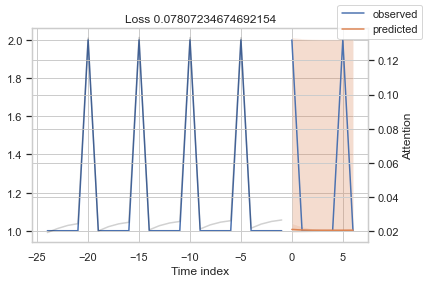

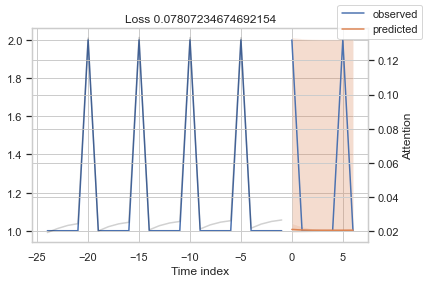

In [111]:
for idx in range(2):  # plot 2 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [112]:
raw_predictions

Output(prediction=tensor([[[0.9904, 1.0037, 1.0014, 1.0069, 1.0389, 2.0048, 2.0131],
         [0.9924, 1.0000, 1.0001, 1.0037, 1.0219, 2.0025, 2.0069],
         [0.9948, 0.9991, 0.9997, 1.0026, 1.0111, 2.0009, 2.0041],
         [0.9963, 0.9990, 0.9993, 1.0024, 1.0059, 2.0002, 2.0032],
         [0.9966, 0.9991, 0.9990, 1.0024, 1.0037, 2.0000, 2.0031],
         [0.9963, 0.9992, 0.9987, 1.0024, 1.0029, 2.0001, 2.0034],
         [0.9965, 0.9995, 0.9984, 1.0027, 1.0023, 2.0003, 2.0039]],

        [[0.9904, 1.0037, 1.0014, 1.0069, 1.0389, 2.0048, 2.0131],
         [0.9924, 1.0000, 1.0001, 1.0037, 1.0219, 2.0025, 2.0069],
         [0.9948, 0.9991, 0.9997, 1.0026, 1.0111, 2.0009, 2.0041],
         [0.9963, 0.9990, 0.9993, 1.0024, 1.0059, 2.0002, 2.0032],
         [0.9966, 0.9991, 0.9990, 1.0024, 1.0037, 2.0000, 2.0031],
         [0.9963, 0.9992, 0.9987, 1.0024, 1.0029, 2.0001, 2.0034],
         [0.9965, 0.9995, 0.9984, 1.0027, 1.0023, 2.0003, 2.0039]],

        [[0.9904, 1.0037, 1.0014, 1.0069

### Worst performers

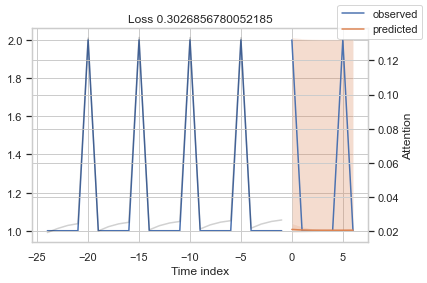

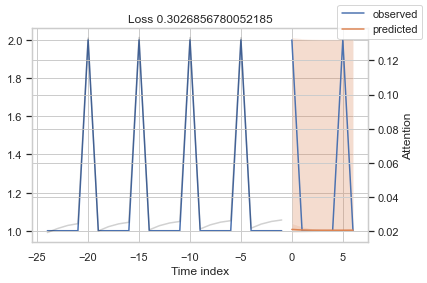

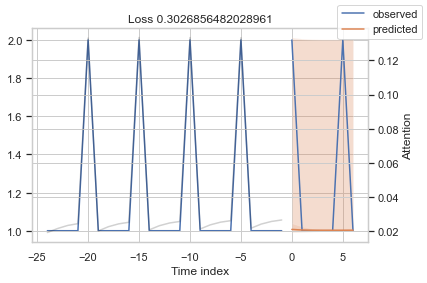

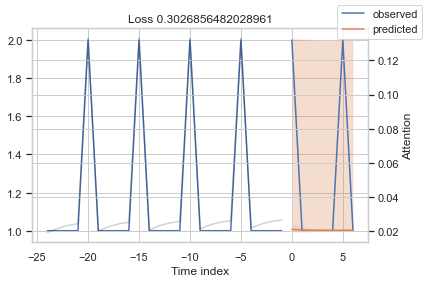

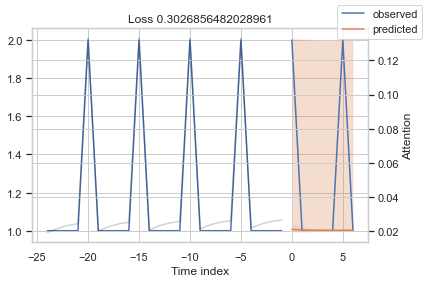

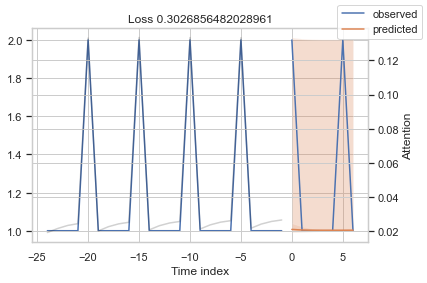

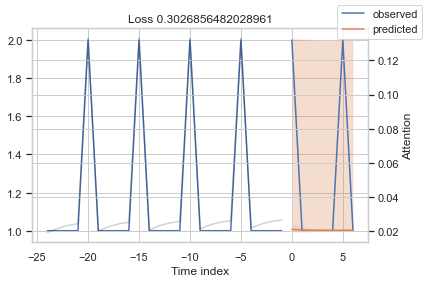

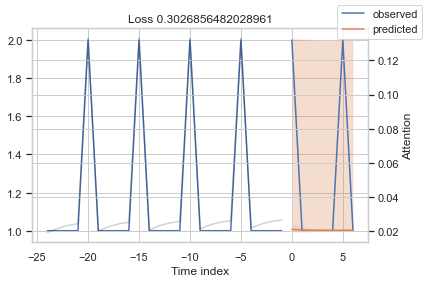

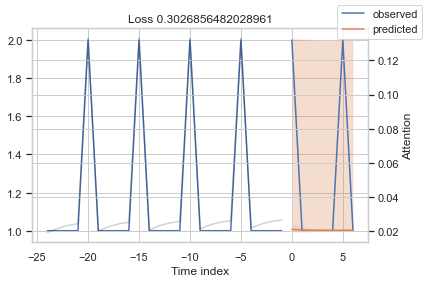

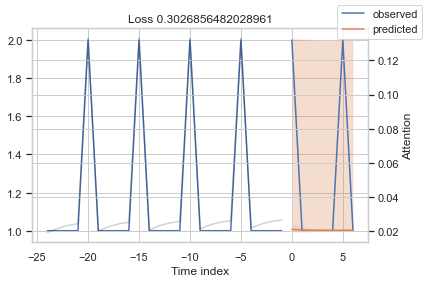

In [113]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

### Actuals vs predictions by variables

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Predict on selected data

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.userID == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

Of course, we can also plot this prediction readily:

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

## Predict on new data

Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

## Interpret model

### Variable importances

In [1]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

NameError: name 'best_tft' is not defined

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.

### Partial dependency

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);